In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu 
from scipy import stats
import matplotlib.ticker as ticker

from mri_data import file_manager as fm

In [8]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = msmri_home / "monai_analysis" / "choroid_pineal_pituitary_FLAIR-1"

## Data Cleaning

Load volume dataset

In [9]:
df_vols = pd.read_csv(curr_dir / "clinical_data_full.csv")
df_vols = df_vols.set_index("subid")
keep_cols = [
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
    "tiv",
    "flair_contrast",
    "label",
    "scan_folder",
    "age",
]

not_nas = (
    ~df_vols["pineal_volume"].isna()
    & ~df_vols["choroid_volume"].isna()
    & ~df_vols["pituitary_volume"].isna()
)
df_vols = df_vols.loc[not_nas, keep_cols]

In [10]:
def subject_to_subid(subject):
    if not isinstance(subject, str):
        return None
    re_match = re.match(r"ms(\d{4})", subject)
    if re_match:
        return_val = int(re_match[1])
        return return_val
    else:
        return None

In [11]:
df_full = pd.read_csv(msmri_datadir / "Clinical_Data_All_updated.csv")
df_full.insert(0, "subid", df_full["ID"].map(subject_to_subid))
df_full = df_full.set_index("subid")

df = pd.merge(
    df_vols,
    df_full.loc[:, ~df_full.columns.isin(df_vols.columns)],
    how="outer",
    on="subid",
)

df.loc[:, "extracted_EDSS"] = [
    float(val) if val != "." else None for val in df["extracted_EDSS"]
]  #! figure out what to do with "."
df.loc[:, ["EDSS"]] = pd.Categorical(df["extracted_EDSS"], ordered=True)
df.loc[df["PRL"] == "#VALUE!", "PRL"] = None
df.loc[:, "PRL"] = [
    int(val) if val != "#VALUE!" and val is not None else None for val in df["PRL"]
]
df.loc[df["dzdur"] == "#VALUE!", "dzdur"] = None

In [12]:
prl_levels = [range(0, 1), range(1, 3), range(3, 5), range(5, df["PRL"].max() + 1)]
df.loc[:, ["PRL_LEVEL"]] = None
for i, level in enumerate(prl_levels):
    df.loc[df["PRL"].isin(level), ["PRL_LEVEL"]] = i
df.loc[:, ["PRL_LEVEL"]] = pd.Categorical(df["PRL_LEVEL"], ordered=True)

prl_levels = [range(0, 1), range(1, 4), range(4, df["PRL"].max() + 1)]
df.loc[:, ["PRL_LEVEL2"]] = None
for i, level in enumerate(prl_levels):
    df.loc[df["PRL"].isin(level), ["PRL_LEVEL2"]] = i
df.loc[:, ["PRL_LEVEL2"]] = pd.Categorical(df["PRL_LEVEL2"], ordered=True)

prl_levels = [range(0, 1), range(1, df["PRL"].max() + 1)]
df.loc[:, ["IS_PRL"]] = None
for i, level in enumerate(prl_levels):
    df.loc[df["PRL"].isin(level), ["IS_PRL"]] = i
df.loc[:, ["IS_PRL"]] = pd.Categorical(df["IS_PRL"], ordered=True)

In [13]:
df.loc[df["extracted_EDSS"] == ".", "extracted_EDSS"] = None

In [14]:
def check_nind(subtype):
    if type(subtype) is not str:
        return False
    if "migraine" in subtype:
        return True
    elif "IIH" in subtype:
        return True
    elif "Migraine" in subtype:
        return True
    else:
        return False

In [15]:
def check_nind2(subtype):
    if type(subtype) is not str:
        return False
    keywords = ["migraine", "IIH", "anxiety", "Migraine"]
    for word in keywords:
        if word in subtype:
            return True
    return False

Add columns for volumes normalized by TIV

In [16]:
df.loc[:, ["norm_choroid_volume"]] = df["choroid_volume"] / df["tiv"]
df.loc[:, ["norm_pineal_volume"]] = df["pineal_volume"] / df["tiv"]
df.loc[:, ["norm_pituitary_volume"]] = df["pituitary_volume"] / df["tiv"]

### Categorize Disease Types

- RMS vs MS vs !MS
- MS vs !MS
- MS vs OIND vs NIND

`dz_type` has relapsing MS (RMS) versus progressive MS (PMS) verusus not MS (!MS)

In [17]:
try:
    df.insert(18, "dz_type", df["ms_type"])
except Exception:
    pass

df.loc[:, "dz_type"] = df["ms_type"]

df.loc[df["ms_type"].isin(["CIS", "RRMS"]), "dz_type"] = "RMS"
df.loc[df["ms_type"].isin(["PPMS", "SPMS", "RPMS", "PRMS"]), "dz_type"] = "PMS"
df.loc[df["ms_type"].isin(["NIND", "OIND", "HC"]), "dz_type"] = "!MS"
# df.loc[(df['dz_type'] == "NIND") & (df['subtype'].map(check_nind2)), "dz_type"] = "HC"
print(df["dz_type"].unique())
print(sum(df["dz_type"] == "HC"))

['RMS' 'PMS' '!MS' 'UNK' 'RIS']
0


`dz_type2` has MS versus !MS and UNK

In [18]:
try:
    df.insert(18, "dz_type2", df["dz_type"])
except Exception:
    pass

df.loc[:, "dz_type2"] = df["ms_type"]
df.loc[df["ms_type"].isin(["NIND", "OIND", "HC"]), "dz_type2"] = "!MS"
df.loc[df["ms_type"].isin(["PPMS", "SPMS", "RPMS", "PRMS", "CIS", "RRMS"]), "dz_type2"] = "MS"
df["dz_type2"].unique()

array(['MS', '!MS', 'UNK', 'RIS'], dtype=object)

`dz_type3` has MS v OIND v NIND

In [19]:
try:
    df.insert(18, "dz_type3", df["ms_type"])
except Exception:
    pass

df.loc[:, "dz_type3"] = df["ms_type"]

df.loc[
    df["ms_type"].isin(["PPMS", "SPMS", "RPMS", "PRMS", "RRMS", "CIS"]), "dz_type3"
] = "MS"
df["dz_type3"].unique()

array(['MS', 'NIND', 'UNK', 'HC', 'OIND', 'RIS'], dtype=object)

`dz_type4`

In [20]:
try:
    df.insert(18, "dz_type4", df["dz_type3"])
except Exception:
    pass

df.loc[:, "dz_type4"] = df["dz_type3"]

df.loc[
    (df["dz_type4"] == "NIND") & (df.loc[:, "subtype"].map(check_nind2)), "dz_type4"
] = "HC"

`dz_type5`

In [21]:
try:
    df.insert(18, "dz_type5", df["ms_type"])
except Exception:
    pass

df.loc[:, "dz_type5"] = df["ms_type"]

df.loc[df["ms_type"].isin(["CIS", "RRMS"]), "dz_type5"] = "RMS"
df.loc[df["ms_type"].isin(["PPMS", "SPMS", "RPMS", "PRMS"]), "dz_type5"] = "PMS"
# df.loc[(df['dz_type5'] == "NIND") & (df['subtype'].map(check_nind2)), "dz_type5"] = "HC"
print(df["dz_type5"].unique())

['RMS' 'PMS' 'NIND' 'UNK' 'HC' 'OIND' 'RIS']


## Descriptive Stats

In [22]:
print(len(df), "patients in total")
nRMS = sum(df["dz_type"] == "RMS")
nPMS = sum(df["dz_type"] == "PMS")
nNotMS = sum(df["dz_type"] == "!MS")
print(nRMS, "patients with RMS", f"({round(nRMS / len(df), 2)})")
print(nPMS, "patients with PMS", f"({round(nPMS / len(df), 2)})")
print(nNotMS, "patients w/o MS", f"({round(nNotMS / len(df), 2)})")

564 patients in total
368 patients with RMS (0.65)
97 patients with PMS (0.17)
92 patients w/o MS (0.16)


In [23]:
print(len(df), "patients in total")
nMS = sum(df["dz_type3"] == "MS")
nOIND = sum(df["dz_type3"] == "OIND")
nNIND = sum(df["dz_type3"] == "NIND")
print(nMS, "patients with MS", f"({round(nMS / len(df), 2)})")
print(nOIND, "patients with OIND", f"({round(nOIND / len(df), 2)})")
print(nNIND, "patients w/o NIND", f"({round(nNIND / len(df), 2)})")

564 patients in total
465 patients with MS (0.82)
41 patients with OIND (0.07)
49 patients w/o NIND (0.09)


In [24]:
print("Female subjects:     {:0.2f}".format(sum(df["sex"] == "Female") / len(df)))
print("Average age at scan: {:0.2f}".format(df["age"].mean()))

Female subjects:     0.79
Average age at scan: 47.73


In [25]:
df_rrms = df.loc[df["dz_type"] == "RMS"]
print("RMS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_rrms["sex"] == "Female") / len(df_rrms)))
print("\tAge:     {:0.2f}".format(df_rrms["age"].mean()))

df_pms = df.loc[df["dz_type"] == "PMS"]
print("PMS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_pms["sex"] == "Female") / len(df_pms)))
print("\tAge:     {:0.2f}".format(df_pms["age"].mean()))

df_notms = df.loc[df["dz_type"] == "!MS"]
print("!MS Patients:")
print("\tFemale:  {:0.2f}".format(sum(df_notms["sex"] == "Female") / len(df_notms)))
print("\tAge:     {:0.2f}".format(df_notms["age"].mean()))

RMS Patients:
	Female:  0.84
	Age:     44.55
PMS Patients:
	Female:  0.59
	Age:     58.30
!MS Patients:
	Female:  0.82
	Age:     49.57


#### Volumes

In [26]:
# choroid
print("Choroid volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms["choroid_volume"].mean()))
print("\tPMS:    {:0.2f}".format(df_pms["choroid_volume"].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms["choroid_volume"].mean()))

# pineal
print("Pineal volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms["pineal_volume"].mean()))
print("\tPMS:    {:0.2f}".format(df_pms["pineal_volume"].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms["pineal_volume"].mean()))

# pituitary
print("Pituitary volumes:")
print("\tRRMS:   {:0.2f}".format(df_rrms["pituitary_volume"].mean()))
print("\tPMS:    {:0.2f}".format(df_pms["pituitary_volume"].mean()))
print("\tnot-MS: {:0.2f}".format(df_notms["pituitary_volume"].mean()))

Choroid volumes:
	RRMS:   1927.14
	PMS:    2203.40
	not-MS: 1960.97
Pineal volumes:
	RRMS:   237.07
	PMS:    217.64
	not-MS: 263.39
Pituitary volumes:
	RRMS:   722.91
	PMS:    729.09
	not-MS: 712.19


In [27]:
print("Choroid volumes:")
choroid_ms_mean = df[df["dz_type2"] == "MS"].choroid_volume.mean()
choroid_notms_mean = df[df["dz_type2"] == "!MS"].choroid_volume.mean()
print("\tMS:     {:0.2f}".format(choroid_ms_mean))
print("\tnot-MS: {:0.2f}".format(choroid_notms_mean))

print("\nPineal volumes")
pineal_ms_mean = df[df["dz_type2"] == "MS"].pineal_volume.mean()
pineal_notms_mean = df[df["dz_type2"] == "!MS"].pineal_volume.mean()
print("\tMS:     {:0.2f}".format(pineal_ms_mean))
print("\tnot-MS: {:0.2f}".format(pineal_notms_mean))

print("\nPituitary volumes")
pituitary_ms_mean = df[df["dz_type2"] == "MS"].pituitary_volume.mean()
pituitary_notms_mean = df[df["dz_type2"] == "!MS"].pituitary_volume.mean()
print("\tMS:     {:0.2f}".format(pituitary_ms_mean))
print("\tnot-MS: {:0.2f}".format(pituitary_notms_mean))

Choroid volumes:
	MS:     1984.93
	not-MS: 1960.97

Pineal volumes
	MS:     233.01
	not-MS: 263.39

Pituitary volumes
	MS:     724.20
	not-MS: 712.19


In [28]:
print("Choroid volumes:")
choroid_ms_mean = df[df["dz_type3"] == "MS"].choroid_volume.mean()
choroid_oind_mean = df[df["dz_type3"] == "OIND"].choroid_volume.mean()
choroid_nind_mean = df[df["dz_type3"] == "NIND"].choroid_volume.mean()
print("\tMS:   {:0.2f}".format(choroid_ms_mean))
print("\tOIND: {:0.2f}".format(choroid_oind_mean))
print("\tNIND: {:0.2f}".format(choroid_nind_mean))


print("\nPineal volumes")
pineal_ms_mean = df[df["dz_type2"] == "MS"].pineal_volume.mean()
pineal_oind_mean = df[df["dz_type3"] == "OIND"].pineal_volume.mean()
pineal_nind_mean = df[df["dz_type3"] == "NIND"].pineal_volume.mean()
print("\tMS:   {:0.2f}".format(pineal_ms_mean))
print("\tOIND: {:0.2f}".format(pineal_oind_mean))
print("\tNIND: {:0.2f}".format(pineal_nind_mean))


print("\nPituitary volumes")
pituitary_ms_mean = df[df["dz_type2"] == "MS"].pituitary_volume.mean()
pituitary_oind_mean = df[df["dz_type3"] == "OIND"].pituitary_volume.mean()
pituitary_nind_mean = df[df["dz_type3"] == "NIND"].pituitary_volume.mean()
print("\tMS:   {:0.2f}".format(pituitary_ms_mean))
print("\tOIND: {:0.2f}".format(pituitary_oind_mean))
print("\tNIND: {:0.2f}".format(pituitary_nind_mean))

Choroid volumes:
	MS:   1984.93
	OIND: 2013.21
	NIND: 1940.35

Pineal volumes
	MS:   233.01
	OIND: 236.75
	NIND: 287.80

Pituitary volumes
	MS:   724.20
	OIND: 729.93
	NIND: 698.48


## Plots

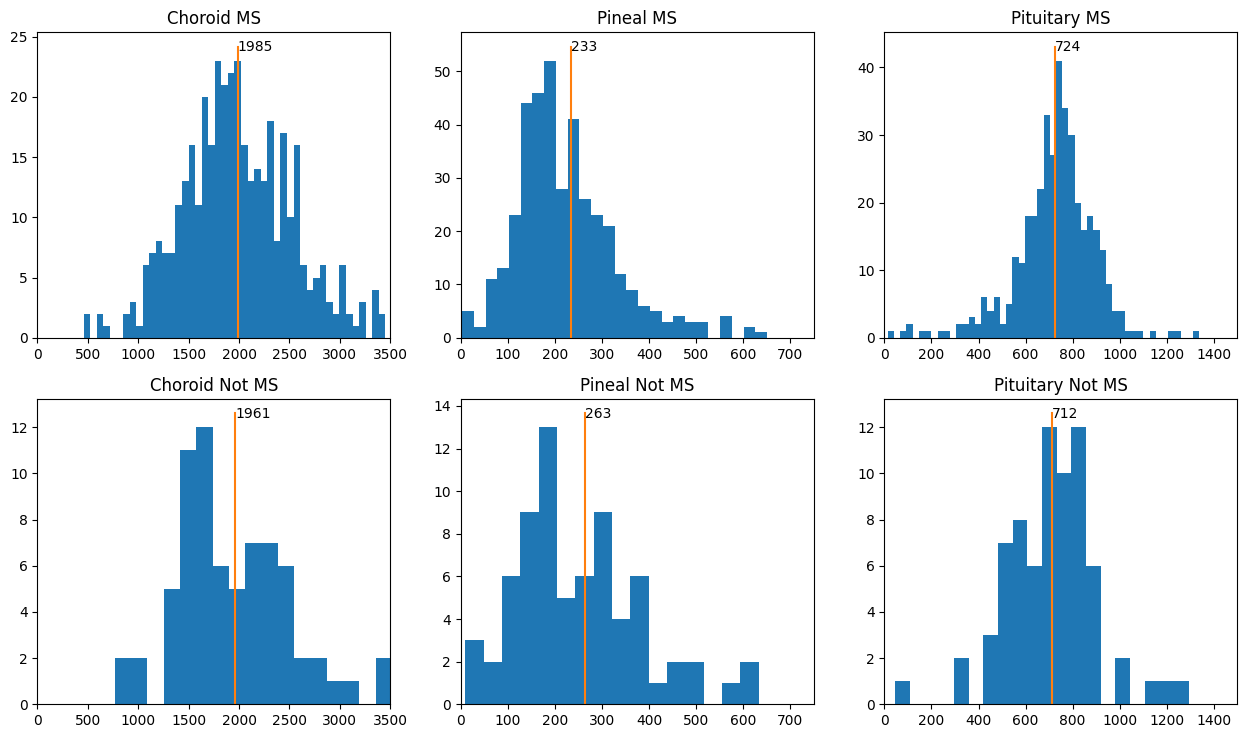

In [29]:
fig, ax = plt.subplots(2, 3)
ax[0, 0].hist(df.loc[df["dz_type2"] == "MS", "choroid_volume"], bins=50)
ax[0, 0].set_xlim([0, 3500])
ax[0, 0].set_title("Choroid MS")
ax[0, 0].plot([choroid_ms_mean, choroid_ms_mean], ax[0, 0].get_ylim())
text_y = ax[0, 0].get_ylim()[1] - ax[0, 0].get_ylim()[1] / 16
ax[0, 0].text(choroid_ms_mean, text_y, "{:0.0f}".format(choroid_ms_mean))

ax[1, 0].hist(df.loc[df["dz_type2"] == "!MS", "choroid_volume"], bins=20)
ax[1, 0].set_xlim([0, 3500])
ax[1, 0].set_title("Choroid Not MS")
ax[1, 0].plot([choroid_notms_mean, choroid_notms_mean], ax[1, 0].get_ylim())
text_y = ax[1, 0].get_ylim()[1] - ax[1, 0].get_ylim()[1] / 16
ax[1, 0].text(choroid_notms_mean, text_y, "{:0.0f}".format(choroid_notms_mean))


ax[0, 1].hist(df.loc[df["dz_type2"] == "MS", "pineal_volume"], bins=50)
ax[0, 1].set_xlim([0, 750])
ax[0, 1].set_title("Pineal MS")
ax[0, 1].plot([pineal_ms_mean, pineal_ms_mean], ax[0, 1].get_ylim())
text_y = ax[0, 1].get_ylim()[1] - ax[0, 1].get_ylim()[1] / 16
ax[0, 1].text(pineal_ms_mean, text_y, "{:0.0f}".format(pineal_ms_mean))

ax[1, 1].hist(df.loc[df["dz_type2"] == "!MS", "pineal_volume"], bins=30)
ax[1, 1].set_xlim([0, 750])
ax[1, 1].set_title("Pineal Not MS")
ax[1, 1].plot([pineal_notms_mean, pineal_notms_mean], ax[1, 1].get_ylim())
text_y = ax[1, 1].get_ylim()[1] - ax[1, 1].get_ylim()[1] / 16
ax[1, 1].text(pineal_notms_mean, text_y, "{:0.0f}".format(pineal_notms_mean))


ax[0, 2].hist(df.loc[df["dz_type2"] == "MS", "pituitary_volume"], bins=50)
ax[0, 2].set_xlim([0, 1500])
ax[0, 2].set_title("Pituitary MS")
ax[0, 2].plot([pituitary_ms_mean, pituitary_ms_mean], ax[0, 2].get_ylim())
text_y = ax[0, 2].get_ylim()[1] - ax[0, 2].get_ylim()[1] / 16
ax[0, 2].text(pituitary_ms_mean, text_y, "{:0.0f}".format(pituitary_ms_mean))

ax[1, 2].hist(df.loc[df["dz_type2"] == "!MS", "pituitary_volume"], bins=20)
ax[1, 2].set_xlim([0, 1500])
ax[1, 2].set_title("Pituitary Not MS")
ax[1, 2].plot([pituitary_notms_mean, pituitary_notms_mean], ax[1, 2].get_ylim())
text_y = ax[1, 2].get_ylim()[1] - ax[1, 2].get_ylim()[1] / 16
ax[1, 2].text(pituitary_notms_mean, text_y, "{:0.0f}".format(pituitary_notms_mean))

plt.subplots_adjust(bottom=0.1, right=2, top=1.5)

## Regression Models

Covariates: age, sex, TIV, contrast

### Linear Regression on Volume

Predict volume of structure with the following predictors:

- MS vs Not-MS
- MS vs OIND vs NIND
- RMS vs PMS

#### Choroid Plexus

##### MS vs not-MS

In [30]:
volume = "choroid_volume"

data = df[["dz_type2", "age", "sex", "tiv", "flair_contrast", "dzdur", volume]]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type2"].isin(["MS", "!MS"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type2"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "Male", "tiv", "MS", "intercept"]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     23.11
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           2.06e-17
Time:                        11:25:52   Log-Likelihood:                -3538.0
No. Observations:                 463   AIC:                             7086.
Df Residuals:                     458   BIC:                             7107.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           12.2378      1.897      6.450      0.0

##### MS vs NIND vs OIND

In [31]:
volume = "choroid_volume"

data = df[["dz_type3", "age", "sex", "tiv", "flair_contrast", "dzdur", volume]]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type3"].isin(["MS", "NIND"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type3"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "Female", "tiv", "MS", "intercept"]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     22.74
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           4.85e-17
Time:                        11:25:54   Log-Likelihood:                -3292.7
No. Observations:                 431   AIC:                             6595.
Df Residuals:                     426   BIC:                             6616.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           12.8213      1.957      6.553      0.0

##### PMS v RMS

In [35]:
volume = "choroid_volume"

data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "PRL",
        "extracted_EDSS",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type5"].isin(["RMS", "PMS"])]
data = data[data["flair_contrast"].isin(["WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type5"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "Female", "tiv", "PMS", "intercept"]
# predictors = ['age', 'Female', 'tiv', 'PMS', 'RMS', 'OIND', 'intercept']
res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     15.03
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           2.19e-10
Time:                        11:27:04   Log-Likelihood:                -1205.8
No. Observations:                 158   AIC:                             2422.
Df Residuals:                     153   BIC:                             2437.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           13.1179      3.373      3.889      0.0

MS patients account add lesion volume to predictors. Greater lesion volume is associated with greater choroid volume. PMS is still associated with greater choroid volume compared to RMS

Text(0, 0.5, 'Lesion volume')

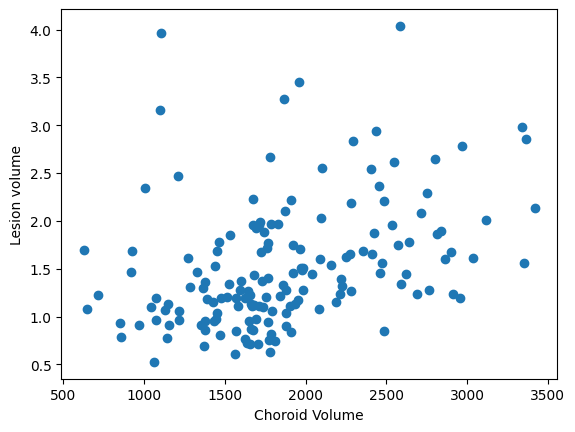

In [36]:
plt.scatter(data['volume'], data['lesion_vol_cubic'])
plt.xlabel("Choroid Volume")
plt.ylabel("Lesion volume")

##### PMS vs RMS vs OIND vs NIND

In [39]:
volume = "choroid_volume"

data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "PRL",
        "lesion_vol_cubic",
        "MSSS",
        "ARMSS",
        "extracted_EDSS"
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type5"].isin(["RMS", "PMS", "NIND", "OIND"])]
data = data[data["flair_contrast"].isin(["WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type5"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

# predictors = ["age", "Female", "tiv", "RMS", "NIND", "OIND", "intercept"]
# predictors = ['age', 'Female', 'tiv', 'PMS', 'RMS', 'OIND', 'intercept']
var = "PRL"
predictors = ["age", "Female", "tiv", "NIND", "OIND", "RMS"]
data_z = data[predictors+["volume"]].astype("float").dropna().apply(stats.zscore)
res = sm.OLS(
    data_z["volume"].astype("float"), data_z[predictors].astype("float"), missing="drop", hasconst=True
).fit()

print(res.summary())
# print(res.params[var])
# print(res.pvalues[var])
# print(res.params[var] - res.conf_int().loc[var,0])

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     11.87
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           6.71e-10
Time:                        11:28:17   Log-Likelihood:                -230.40
No. Observations:                 181   AIC:                             472.8
Df Residuals:                     175   BIC:                             492.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.2676      0.073      3.644      0.0

In [30]:
res.model.exog.shape

(477, 3)

/tmp/ipykernel_340544/782402305.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(lines1.get_xdata(), lines1.get_ydata(), c=[.2, .2, .2])


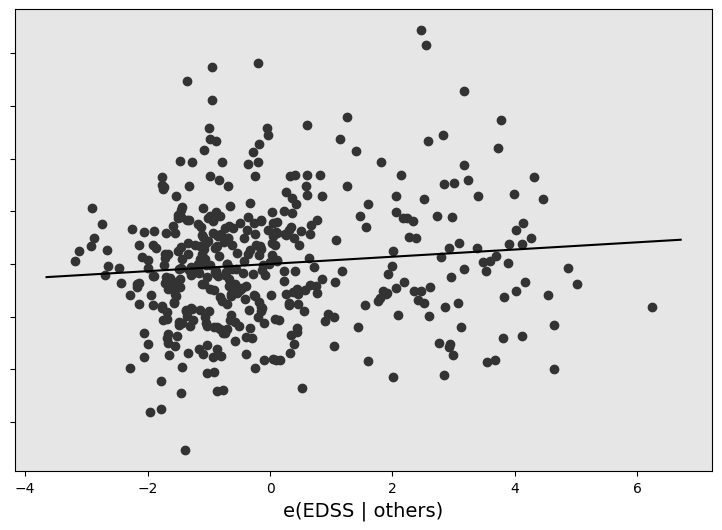

In [31]:
var = "extracted_EDSS"
predictors = ["age", "Female", "tiv", var, "intercept"]
res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

fig = sm.graphics.plot_partregress_grid(res, exog_idx=[var])
ax = fig.get_axes()[0]
lines1 = ax.lines[0]
lines2 = ax.lines[1]
plt.close()
fig = plt.figure(figsize=(9, 6))
plt.scatter(lines1.get_xdata(), lines1.get_ydata(), c=[.2, .2, .2])
plt.plot(lines2.get_xdata(), lines2.get_ydata(), c=[0, 0, 0])
ax = fig.get_axes()[0]
ax.set_facecolor([.9, .9, .9])
# ax.set_alpha(0)
fig.patch.set_alpha(0)
plt.xlabel("e(EDSS | others)", fontsize=14)
plt.ylabel("")
ax.yaxis.set_major_formatter(ticker.NullFormatter())

# x = res.model.exog[:, 3]
# y = res.model.endog
# fitted_line = sm.OLS(y, x).fit()
# plt.scatter(x, y)
# plt.plot(x, fitted_line.predict(x))


/tmp/ipykernel_340544/1733132818.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(lines1.get_xdata(), lines1.get_ydata(), c=[.2, .2, .2])


Text(0, 0.5, 'e(CP_volume | others)')

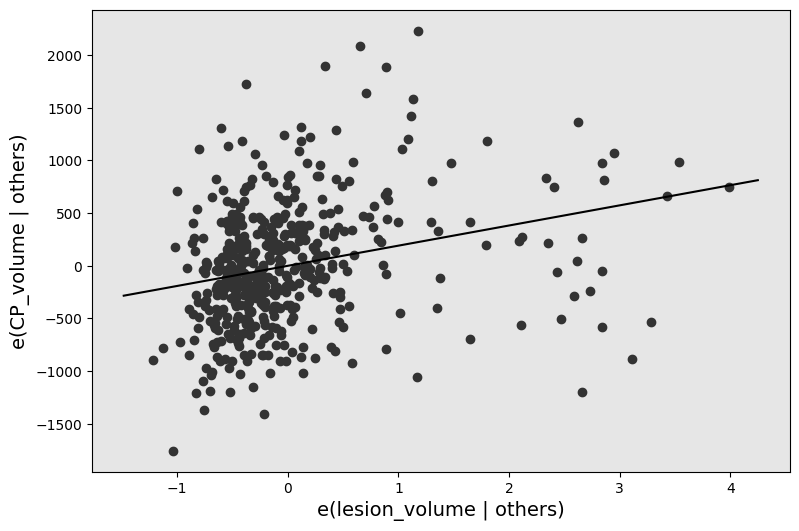

In [32]:
var = "lesion_vol_cubic"
predictors = ["age", "Female", "tiv", var, "intercept"]
res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

fig = sm.graphics.plot_partregress_grid(res, exog_idx=[var])
ax = fig.get_axes()[0]
lines1 = ax.lines[0]
lines2 = ax.lines[1]
plt.close()
fig = plt.figure(figsize=(9, 6))
plt.scatter(lines1.get_xdata(), lines1.get_ydata(), c=[.2, .2, .2])
plt.plot(lines2.get_xdata(), lines2.get_ydata(), c=[0, 0, 0])
ax = fig.get_axes()[0]
ax.set_facecolor([.9, .9, .9])
# ax.set_alpha(0)
fig.patch.set_alpha(0)
plt.xlabel("e(lesion_volume | others)", fontsize=14)
plt.ylabel("e(CP_volume | others)", fontsize=14)

# x = res.model.exog[:, 3]
# y = res.model.endog
# fitted_line = sm.OLS(y, x).fit()
# plt.scatter(x, y)
# plt.plot(x, fitted_line.predict(x))

Marginal Means

In [73]:
volume = "choroid_volume"

data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type5"].isin(["RMS", "PMS", "NIND", "OIND"])]
data = data[data["flair_contrast"].isin(["WITHOUT"])]

data["sex_male"] = data.sex.map({"Female": 0, "Male": 1})

model = ols(
    "volume ~ dz_type5 + sex_male + age + tiv", data=data
).fit()

ancova_table = sm.stats.anova_lm(model, typ=2)


In [74]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     9.837
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           2.48e-09
Time:                        16:17:22   Log-Likelihood:                -1380.6
No. Observations:                 181   AIC:                             2775.
Df Residuals:                     174   BIC:                             2798.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          302.4708    608.571  

/tmp/ipykernel_47851/2539007048.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(x='dz_type5', y=marginal_means, data=data,


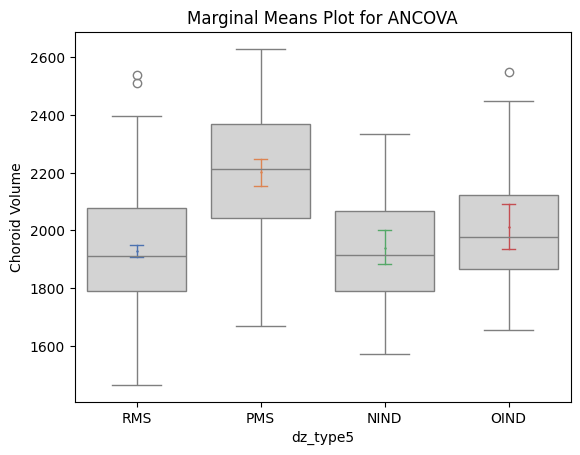

In [43]:
# Extract marginal means (using 'Group')
marginal_means = model.predict(data[['sex_male', 'age', 'tiv', 'dz_type5']].drop_duplicates())

# Plotting
# sns.boxplot(x='dz_type5', y=marginal_means, data=data, color='lightgray')  # Boxplot for context
sns.boxplot(x='dz_type5', y=marginal_means, data=data, color='lightgray')  # Boxplot for context
# sns.stripplot(
#     data=data, x="dz_type5", y="volume",
#     dodge=True, alpha=.2, legend=False,
# )
sns.pointplot(x='dz_type5', y=marginal_means, data=data, 
              palette='deep', markers='o', linestyles='-', color='red',
              markersize=1, capsize=0.1, linewidth=1)

plt.title('Marginal Means Plot for ANCOVA')
# plt.ylim(500, 3500)
plt.ylabel("Choroid Volume")
plt.show()

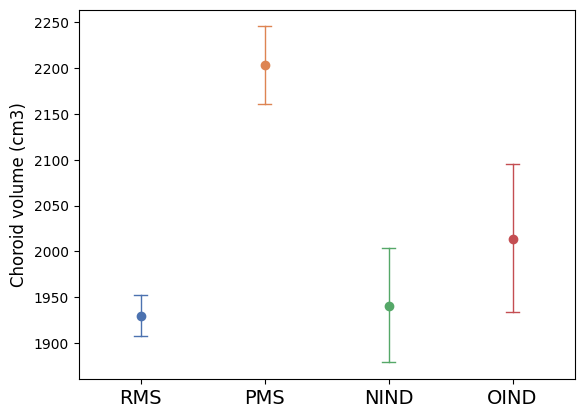

In [44]:
f = plt.figure()
ax = sns.pointplot(x='dz_type5', y=marginal_means, data=data, 
              palette='deep', hue='dz_type5', legend=False, markers='o', linestyles='-', color='red', 
              capsize=0.1, markersize=5, markeredgewidth=2, linewidth=1)
ax.set_ylabel("Choroid volume (cm3)", fontsize=12)
ax.set_xlabel("")
ax.set_xticks(["RMS", "PMS", "NIND", "OIND"])
ax.set_xticklabels(["RMS", "PMS", "NIND", "OIND"], fontsize=14)
f.patch.set_alpha(0)

(1900.0, 2600.0)

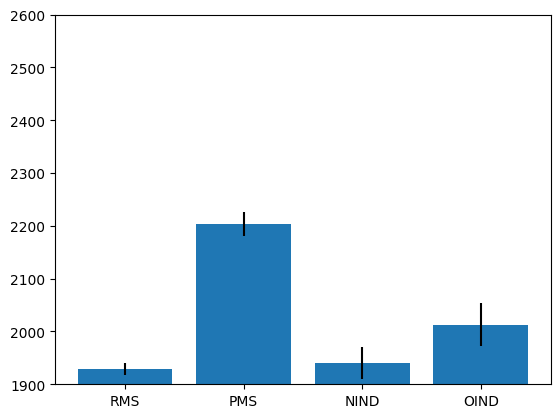

In [45]:
plt.bar(["RMS", "PMS", "NIND", "OIND"], [
    marginal_means[data['dz_type5'] == "RMS"].mean(),
    marginal_means[data['dz_type5'] == "PMS"].mean(),
    marginal_means[data['dz_type5'] == "NIND"].mean(),
    marginal_means[data['dz_type5'] == "OIND"].mean()
], yerr=[
    marginal_means[data['dz_type5'] == "RMS"].sem(),
    marginal_means[data['dz_type5'] == "PMS"].sem(),
    marginal_means[data['dz_type5'] == "NIND"].sem(),
    marginal_means[data['dz_type5'] == "OIND"].sem()
])
plt.ylim([1900, 2600])

Does lesion volume and PRL_LEVEL predict choroid volume in MS patients?

In [ ]:
volume = "choroid_volume"

data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "PRL",
        "extracted_EDSS",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type5"].isin(["RMS", "PMS"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type5"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ['age', 'Female', 'tiv', 'PMS', 'PRL', 'lesion_vol_cubic', 'intercept']
# predictors = ["age", "Female", "tiv", "lesion_vol_cubic", "PRL_LEVEL", "intercept"]
res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     18.88
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           8.67e-17
Time:                        11:29:22   Log-Likelihood:                -2957.2
No. Observations:                 389   AIC:                             5926.
Df Residuals:                     383   BIC:                             5950.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           12.4378      2.224      5.592      0.0

#### Pineal

##### MS vs not-MS

Note: this is significant for MS vs Not-MS, but not when adding disease duration as a covariate

In [39]:
volume = "pineal_volume"

data = df[
    [
        "dz_type2",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "PRL",
        "lesion_vol_cubic",
        "extracted_EDSS"
    ]
]
data = data.drop([1548], axis=0)
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type2"].isin(["MS", "!MS"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type2"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "tiv", "Male", "extracted_EDSS", "intercept"]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     2.694
Date:                Thu, 20 Feb 2025   Prob (F-statistic):             0.0306
Time:                        20:22:36   Log-Likelihood:                -2526.4
No. Observations:                 431   AIC:                             5063.
Df Residuals:                     426   BIC:                             5083.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
age               -0.3507      0.362     -0.

##### MS vs NIND vs OIND

Note: this is significant for MS vs Not-MS, but not when adding disease duration as a covariate

In [40]:
volume = "pineal_volume"

data = df[
    [
        "dz_type3",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "PRL",
        "extracted_EDSS", 
        "MSSS",
        "dzdur",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type3"].isin(["MS", "OIND", "NIND"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]
data = data.drop([1548], axis=0)


data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type3"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

var = "PRL"
predictors = ["age", "Female", "tiv"]
data_z = data[predictors+["volume"]].astype("float").dropna().apply(stats.zscore)
res = sm.OLS(
    data_z["volume"].astype("float"), data_z[predictors].astype("float"), missing="drop", hasconst=True
).fit()

print(res.summary())
# print(res.params[var])
# print(res.pvalues[var])
# print(res.params[var] - res.conf_int().loc[var,0])

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     4.182
Date:                Thu, 20 Feb 2025   Prob (F-statistic):             0.0158
Time:                        20:22:36   Log-Likelihood:                -671.24
No. Observations:                 476   AIC:                             1348.
Df Residuals:                     473   BIC:                             1361.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0625      0.046     -1.348      0.1

/tmp/ipykernel_340544/1361430445.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(lines1.get_xdata(), lines1.get_ydata(), c=[.2, .2, .2])


Text(0, 0.5, 'e(pineal_volume | others)')

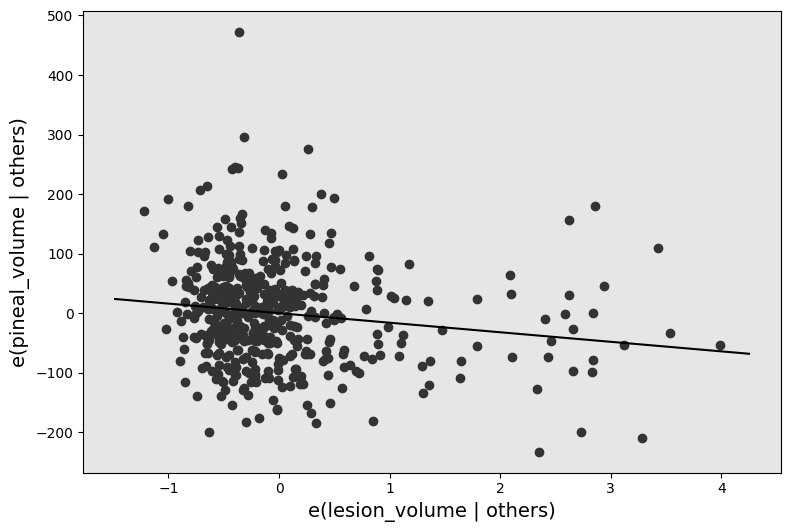

In [41]:
var = "lesion_vol_cubic"
predictors = ["age", "Female", "tiv", var, "intercept"]
res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

fig = sm.graphics.plot_partregress_grid(res, exog_idx=[var])
ax = fig.get_axes()[0]
lines1 = ax.lines[0]
lines2 = ax.lines[1]
plt.close()
fig = plt.figure(figsize=(9, 6))
plt.scatter(lines1.get_xdata(), lines1.get_ydata(), c=[.2, .2, .2])
plt.plot(lines2.get_xdata(), lines2.get_ydata(), c=[0, 0, 0])
ax = fig.get_axes()[0]
ax.set_facecolor([.9, .9, .9])
# ax.set_alpha(0)
fig.patch.set_alpha(0)
plt.xlabel("e(lesion_volume | others)", fontsize=14)
plt.ylabel("e(pineal_volume | others)", fontsize=14)

# x = res.model.exog[:, 3]
# y = res.model.endog
# fitted_line = sm.OLS(y, x).fit()
# plt.scatter(x, y)
# plt.plot(x, fitted_line.predict(x))

1479

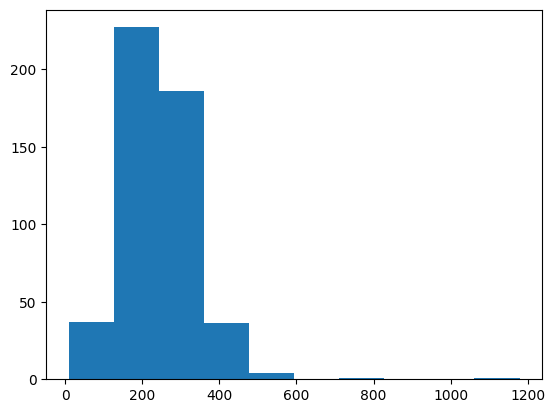

In [42]:
plt.hist(df['pineal_volume'])

median_vol = df['pineal_volume'].median()
tmp_df = df.copy()
tmp_df = tmp_df.sort_values(by="pineal_volume")
tmp_df.index[len(tmp_df) // 2]

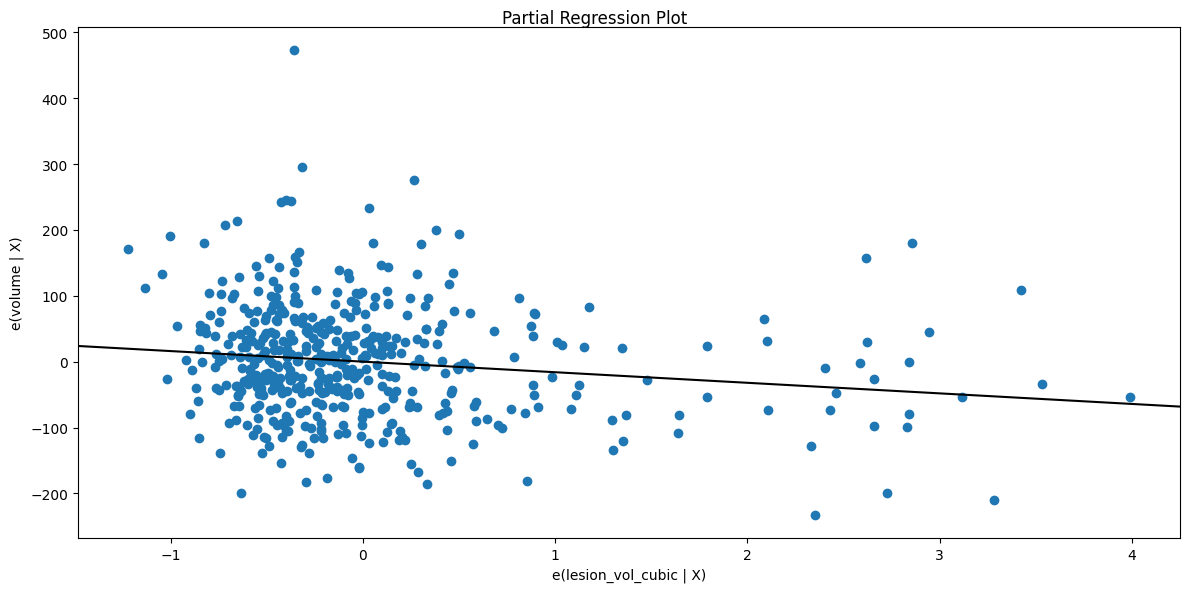

In [43]:
fig = plt.figure(figsize=(12, 6))
sm.graphics.plot_partregress_grid(res, exog_idx=["lesion_vol_cubic"], fig=fig)
plt.show()

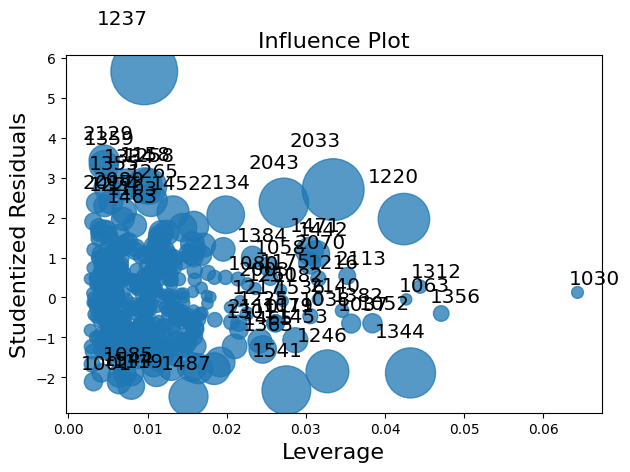

In [44]:
fig = sm.graphics.influence_plot(res, criterion="cooks")
fig.tight_layout(pad=1.0)

##### PMS v RMS

In [45]:
volume = "pineal_volume"

data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "PRL",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type5"].isin(["RMS", "PMS"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type5"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "Female", "tiv", "PMS", "intercept"]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.760
Date:                Thu, 20 Feb 2025   Prob (F-statistic):              0.136
Time:                        20:22:37   Log-Likelihood:                -2361.0
No. Observations:                 405   AIC:                             4732.
Df Residuals:                     400   BIC:                             4752.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.4245      0.362     -1.174      0.2

In [46]:
volume = "pineal_volume"

data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type5"].isin(["RMS", "PMS", "NIND"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]
data = data.drop([1237, 1548], axis=0)
data = data[data['sex'] == "Female"]


data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type5"]),
        pd.get_dummies(data["flair_contrast"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "tiv", "RMS", "PMS", "lesion_vol_cubic", "intercept"]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2.914
Date:                Thu, 20 Feb 2025   Prob (F-statistic):             0.0137
Time:                        20:22:37   Log-Likelihood:                -1996.9
No. Observations:                 343   AIC:                             4006.
Df Residuals:                     337   BIC:                             4029.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -0.4254      0.379  

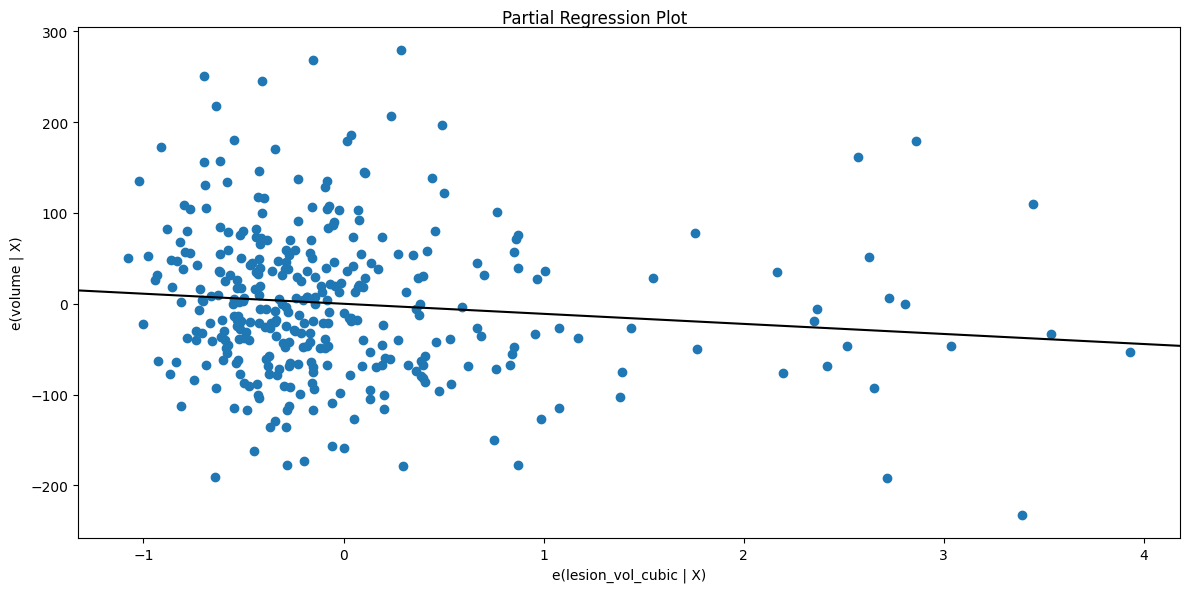

In [47]:
fig = plt.figure(figsize=(12, 6))
sm.graphics.plot_partregress_grid(res, exog_idx=["lesion_vol_cubic"], fig=fig)
plt.show()

2


MannwhitneyuResult(statistic=7474.5, pvalue=0.09187797446145998)

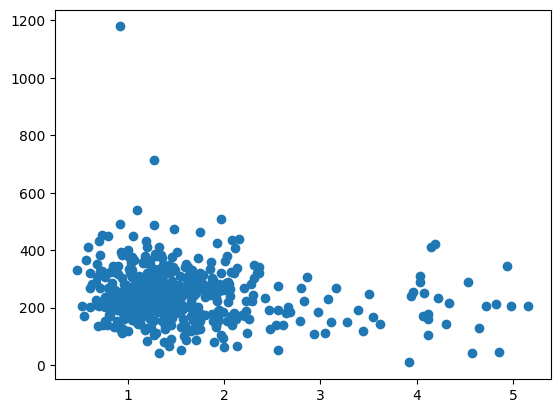

In [48]:
data = df
# data = data.drop([1548], axis=0)
print(data[data['dz_type3'] == "HC"].__len__())

plt.scatter(data['lesion_vol_cubic'], data['pineal_volume'])

# plt.scatter(data.loc[data['dz_type3'] == "MS", 'lesion_vol_cubic'], data.loc[data['dz_type3'] == "MS",'choroid_volume'])

mannwhitneyu(data.loc[data['dz_type3'] == "MS", "pineal_volume"],
         data.loc[data['dz_type3'] == "NIND", "pineal_volume"], 
         nan_policy="omit")

# plt.bar([1,2], [data.loc[data['dz_type3'] == "MS", "pineal_volume"].mean(),
#                 data.loc[data['dz_type3'] == "NIND", "pineal_volume"].mean()],
#                 yerr=[data.loc[data['dz_type3'] == "MS", "pineal_volume"].sem(),
#                       data.loc[data['dz_type3'] == "NIND", "pineal_volume"].sem()],
#                       ecolor="r")

#### Pituitary

##### MS vs not-MS

In [49]:
volume = "pituitary_volume"

data = df[
    [
        "dz_type2",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "PRL",
        "lesion_vol_cubic",
        "dzdur",
        "extracted_EDSS"
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type2"].isin(["MS", "!MS"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type2"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

var = "PRL"
predictors = ["age", "Female", "tiv", var]
data_z = data[predictors+["volume"]].astype("float").dropna().apply(stats.zscore)

res = sm.OLS(
    data_z["volume"].astype("float"), data_z[predictors].astype("float"), missing="drop", hasconst=True
).fit()

print(res.summary())
# print(res.params[var])
# print(res.pvalues[var])
# print(res.params[var] - res.conf_int().loc[var,0])

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     12.29
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           9.40e-08
Time:                        20:22:39   Log-Likelihood:                -658.94
No. Observations:                 477   AIC:                             1326.
Df Residuals:                     473   BIC:                             1343.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.1368      0.046     -2.954      0.0

<BarContainer object of 2 artists>

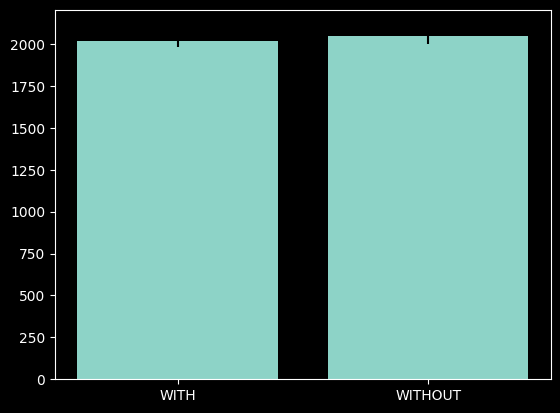

In [51]:
plt.bar(["WITH", "WITHOUT"], [
    df.loc[df['flair_contrast'] == "WITH", "choroid_volume"].mean(),
    df.loc[df['flair_contrast'] == "WITHOUT", "choroid_volume"].mean()
], yerr=[
    df.loc[df['flair_contrast'] == "WITH", "choroid_volume"].sem(),
    df.loc[df['flair_contrast'] == "WITHOUT", "choroid_volume"].sem()
])
# plt.ylim([1800, 2200])


# plt.ylim([1800, 2200])

##### MS vs NIND vs OIND

In [52]:
volume = "pituitary_volume"

data = df[["dz_type3", "age", "sex", "tiv", "flair_contrast", "dzdur", "lesion_vol_cubic", volume]]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type3"].isin(["MS", "OIND", "NIND"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type3"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["age", "Female", "tiv", "MS", "OIND", "intercept"]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     7.715
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           5.47e-07
Time:                        16:16:07   Log-Likelihood:                -2983.1
No. Observations:                 477   AIC:                             5978.
Df Residuals:                     471   BIC:                             6003.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -1.4511      0.473     -3.068      0.0

##### PMS v RMS

In [53]:
volume = "pituitary_volume"

data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "dzdur",
        volume,
        "PRL_LEVEL",
        "lesion_vol_cubic",
    ]
]
data = data.rename(columns={volume: "volume"})
data = data[data["dz_type5"].isin(["RMS", "PMS"])]
data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type5"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = ["tiv", "PMS", "RMS", "intercept"]
predictors = [
    "age",
    "Female",
    "tiv",
    "PMS",
    "PRL_LEVEL",
    "lesion_vol_cubic",
    "intercept",
]

res = sm.OLS(
    data["volume"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     5.250
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           3.21e-05
Time:                        20:27:16   Log-Likelihood:                -2512.9
No. Observations:                 403   AIC:                             5040.
Df Residuals:                     396   BIC:                             5068.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -1.0361      0.586  

In [54]:
predictors = [
    "age",
    "Female",
    "tiv",
    "volume",
    "intercept",
]

res = sm.Logit(
    data["PMS"].astype("float"), data[predictors].astype("float"), missing="drop"
).fit()

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.386105
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    PMS   No. Observations:                  405
Model:                          Logit   Df Residuals:                      400
Method:                           MLE   Df Model:                            4
Date:                Thu, 20 Feb 2025   Pseudo R-squ.:                  0.2485
Time:                        20:28:58   Log-Likelihood:                -156.37
converged:                       True   LL-Null:                       -208.09
Covariance Type:            nonrobust   LLR p-value:                 1.832e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.1091      0.015      7.378      0.000       0.080       0.138
Female        -1.3486      0.

### Ordinal Regression on EDSS

Predict EDSS score using volumes. Use MS vs OIND vs NIND as covariate (in addition to the others). Female sex associated with better EDSS when age and choroid volume are discluded from model

In [70]:
data = df[
    [
        "dz_type3",
        "dz_type",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "extracted_EDSS",
        "ARMSS",
        "PRL_LEVEL",
        # "PRL_LEVEL2",
        "PRL",
        # "IS_PRL",
        "lesion_vol_cubic",
        "MSSS",
        "choroid_volume",
        "pineal_volume",
        "pituitary_volume",
        "thalamus",
        "brain",
        "cortical_thickness",
        "dzdur",
    ]
]
data = data[data["dz_type3"].isin(["MS"])]
data.loc[:, ["dz_type3_factor"]], _ = data["dz_type3"].factorize(sort=False)

data = data[data["flair_contrast"].isin(["WITH"])]
# df['extracted_EDSS'] = df['extracted_EDSS'] * 2
data.loc[data["extracted_EDSS"] == ".", "extracted_EDSS"] = None
# data['extracted_EDSS'] = pd.Categorical(data['extracted_EDSS'], ordered=True)

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

predictors = [
    "tiv",
    "age",
    "Female",
    "choroid_volume"]

data = data.dropna()
data["EDSS"] = np.sqrt(data["extracted_EDSS"].astype("float"))
data_z = data[predictors+["EDSS"]].astype("float").dropna().apply(stats.zscore)
# mod = OrderedModel(data2['numEDSS'],
#                    data2[predictors].astype('float'), distr='probit', disp=False)
# res = mod.fit(method='nm')

res = sm.OLS(
    data_z["EDSS"].astype("float"), data_z[predictors].astype("float"), has_const=True
).fit(missing="drop")

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                   EDSS   R-squared (uncentered):                   0.158
Model:                            OLS   Adj. R-squared (uncentered):              0.142
Method:                 Least Squares   F-statistic:                              9.767
Date:                Thu, 27 Feb 2025   Prob (F-statistic):                    2.93e-07
Time:                        12:08:27   Log-Likelihood:                         -282.57
No. Observations:                 212   AIC:                                      573.1
Df Residuals:                     208   BIC:                                      586.6
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['has_const']
  warnings.warn(msg, ValueWarning)


(array([290.,  40.,  25.,   2.,   6.,   3.,   1.,   0.,   1.,   2.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

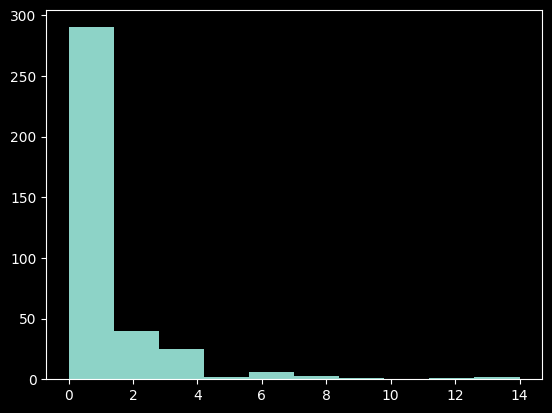

In [66]:
plt.hist(data['PRL'])

In [75]:
fig = plt.figure(figsize=(12, 6))
sm.graphics.plot_partregress_grid(res, exog_idx=["choroid_volume", "age"], fig=fig)
plt.show()

ValueError: 'choroid_volume' is not in list

<Figure size 1200x600 with 0 Axes>

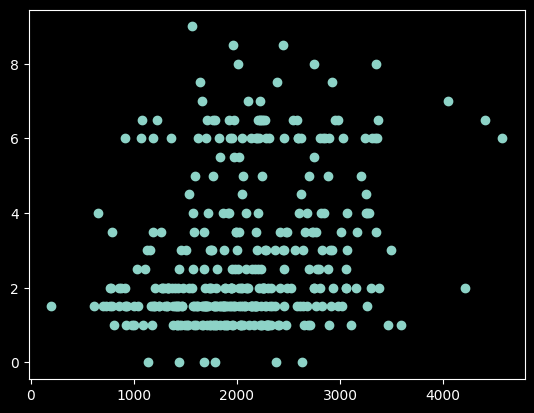

In [ ]:
plt.scatter(data['choroid_volume'], data['extracted_EDSS'])

```mermaid
graph LR;
    Lesion_vol --> EDSS;
    CP_vol --> EDSS;
    CP_vol --> Lesion_vol;
```

Exposure: `CP_vol`  
Mediator: `Lesion_vol`

`EDSS ~ CP_vol + Lesion_vol + TIV + age + sex`  

`Lesion_vol ~ CP_vol + TIV + age + sex`

In [ ]:
from statsmodels.stats.mediation import Mediation
data = df[
    [
        "dz_type3",
        "age",
        "sex",
        "tiv",
        "extracted_EDSS",
        "PRL_LEVEL",
        "PRL_LEVEL2",
        "PRL",
        "IS_PRL",
        "lesion_vol_cubic",
        "choroid_volume",
        "pineal_volume",
        "pituitary_volume",
        "dzdur",
    ]
]

data = pd.concat(
    (
        data,
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)

data.loc[data["extracted_EDSS"] == ".", "extracted_EDSS"] = None

vars = ["choroid_volume", "extracted_EDSS", "age", "Female", "tiv", "lesion_vol_cubic"]

data = data[vars].astype("float")
data = data.dropna()

outcome_model = sm.OLS.from_formula("extracted_EDSS ~ choroid_volume + lesion_vol_cubic + age + tiv", data=data)

mediator_model = sm.OLS.from_formula("lesion_vol_cubic ~ choroid_volume + age + tiv", data=data)

med = Mediation(outcome_model, mediator_model, "choroid_volume", "lesion_vol_cubic").fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.001304,-0.040053,0.039298,0.952
ACME (treated),0.001304,-0.040053,0.039298,0.952
ADE (control),0.000201,-0.000070,0.000472,0.164
ADE (treated),0.000201,-0.000070,0.000472,0.164
Total effect,0.001505,-0.040083,0.039336,0.938
Prop. mediated (control),0.998525,0.765058,1.244872,0.014
Prop. mediated (treated),0.998525,0.765058,1.244872,0.014
ACME (average),0.001304,-0.040053,0.039298,0.952
ADE (average),0.000201,-0.000070,0.000472,0.164
Prop. mediated (average),0.998525,0.765058,1.244872,0.014


In [58]:
from statsmodels.stats.mediation import Mediation
data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "extracted_EDSS",
        "PRL_LEVEL",
        "PRL_LEVEL2",
        "PRL",
        "IS_PRL",
        "lesion_vol_cubic",
        "choroid_volume",
        "pineal_volume",
        "pituitary_volume",
        "dzdur",
    ]
]

data = data[data["dz_type5"].isin(["RMS", "PMS"])]


data = pd.concat(
    (
        data,
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)

data.loc[data["extracted_EDSS"] == ".", "extracted_EDSS"] = None

vars = ["choroid_volume", "extracted_EDSS", "age", "Female", "tiv", "lesion_vol_cubic"]

data = data[vars].astype("float")
data = data.dropna()

outcome_model = sm.OLS.from_formula("extracted_EDSS ~ choroid_volume + lesion_vol_cubic + age + Female + tiv", data=data)

mediator_model = sm.OLS.from_formula("choroid_volume ~ lesion_vol_cubic + age + Female + tiv", data=data)

med = Mediation(outcome_model, mediator_model, "lesion_vol_cubic", "choroid_volume").fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.033067,-0.029960,0.105222,0.308
ACME (treated),0.033067,-0.029960,0.105222,0.308
ADE (control),0.366802,0.152107,0.580314,0.000
ADE (treated),0.366802,0.152107,0.580314,0.000
Total effect,0.399869,0.192216,0.603345,0.000
Prop. mediated (control),0.080395,-0.096934,0.313093,0.308
Prop. mediated (treated),0.080395,-0.096934,0.313093,0.308
ACME (average),0.033067,-0.029960,0.105222,0.308
ADE (average),0.366802,0.152107,0.580314,0.000
Prop. mediated (average),0.080395,-0.096934,0.313093,0.308


In [86]:
from statsmodels.stats.mediation import Mediation
data = df[
    [
        "dz_type5",
        "age",
        "sex",
        "tiv",
        "extracted_EDSS",
        "PRL_LEVEL",
        "PRL_LEVEL2",
        "PRL",
        "IS_PRL",
        "lesion_vol_cubic",
        "choroid_volume",
        "pineal_volume",
        "pituitary_volume",
        "dzdur",
    ]
]

data = data[data["dz_type5"].isin(["RMS", "PMS"])]


data = pd.concat(
    (
        data,
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)

data.loc[data["extracted_EDSS"] == ".", "extracted_EDSS"] = None

vars = ["choroid_volume", "extracted_EDSS", "age", "Female", "tiv", "lesion_vol_cubic", "PRL"]

data = data[vars].astype("float")
data = data.dropna()

outcome_model = sm.OLS.from_formula("extracted_EDSS ~ PRL + lesion_vol_cubic + age + Female + tiv", data=data)

mediator_model = sm.OLS.from_formula("lesion_vol_cubic ~ PRL + age + Female + tiv + choroid_volume", data=data)

med = Mediation(outcome_model, mediator_model, "PRL", "lesion_vol_cubic").fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.021374,-0.028377,0.073090,0.298
ACME (treated),0.021374,-0.028377,0.073090,0.298
ADE (control),0.074983,-0.015953,0.165690,0.116
ADE (treated),0.074983,-0.015953,0.165690,0.116
Total effect,0.096358,-0.003617,0.192921,0.056
Prop. mediated (control),0.210077,-0.773130,1.339368,0.282
Prop. mediated (treated),0.210077,-0.773130,1.339368,0.282
ACME (average),0.021374,-0.028377,0.073090,0.298
ADE (average),0.074983,-0.015953,0.165690,0.116
Prop. mediated (average),0.210077,-0.773130,1.339368,0.282


In [59]:
data = df[
    [
        "dz_type3",
        "age",
        "sex",
        "tiv",
        "extracted_EDSS",
        "PRL_LEVEL",
        "PRL_LEVEL2",
        "PRL",
        "IS_PRL",
        "lesion_vol_cubic",
        "choroid_volume",
        "pineal_volume",
        "pituitary_volume",
        "MSSS",
        "dzdur",
    ]
]
# data = data[data["dz_type3"].isin(["MS"])]
data.loc[:, ["dz_type3_factor"]], _ = data["dz_type3"].factorize(sort=False)

# df['extracted_EDSS'] = df['extracted_EDSS'] * 2
data.loc[data["extracted_EDSS"] == ".", "extracted_EDSS"] = None
# data['extracted_EDSS'] = pd.Categorical(data['extracted_EDSS'], ordered=True)

data = pd.concat(
    (
        data,
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data = data.dropna()
data["extracted_EDSS"] = data["extracted_EDSS"].astype("float")
data["intercept"] = 1
fit = ols('extracted_EDSS ~ tiv + age + Female + choroid_volume + lesion_vol_cubic', data=data).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:         extracted_EDSS   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     21.75
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           2.98e-19
Time:                        16:17:48   Log-Likelihood:                -789.06
No. Observations:                 401   AIC:                             1590.
Df Residuals:                     395   BIC:                             1614.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0891      1.404  

In [168]:
data['PRL']

subid
1001    0
1002    4
1003    0
1004    0
1005    0
       ..
2131    1
2133    0
2135    1
2137    0
2140    3
Name: PRL, Length: 395, dtype: object

In [136]:
predictors = [
    "age",
    "Female",
    "tiv",
    "PRL_LEVEL2",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
    "dzdur",
    "intercept",
]

data = data.dropna()

# mod = OrderedModel(data2['numEDSS'],
#                    data2[predictors].astype('float'), distr='probit', disp=False)
# res = mod.fit(method='nm')

res = sm.OLS(
    data["extracted_EDSS"].astype("float"), data[predictors].astype("float")
).fit(missing="drop")

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         extracted_EDSS   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     13.88
Date:                Tue, 11 Feb 2025   Prob (F-statistic):           1.32e-17
Time:                        12:53:48   Log-Likelihood:                -725.53
No. Observations:                 370   AIC:                             1469.
Df Residuals:                     361   BIC:                             1504.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  0.0402      0.010  

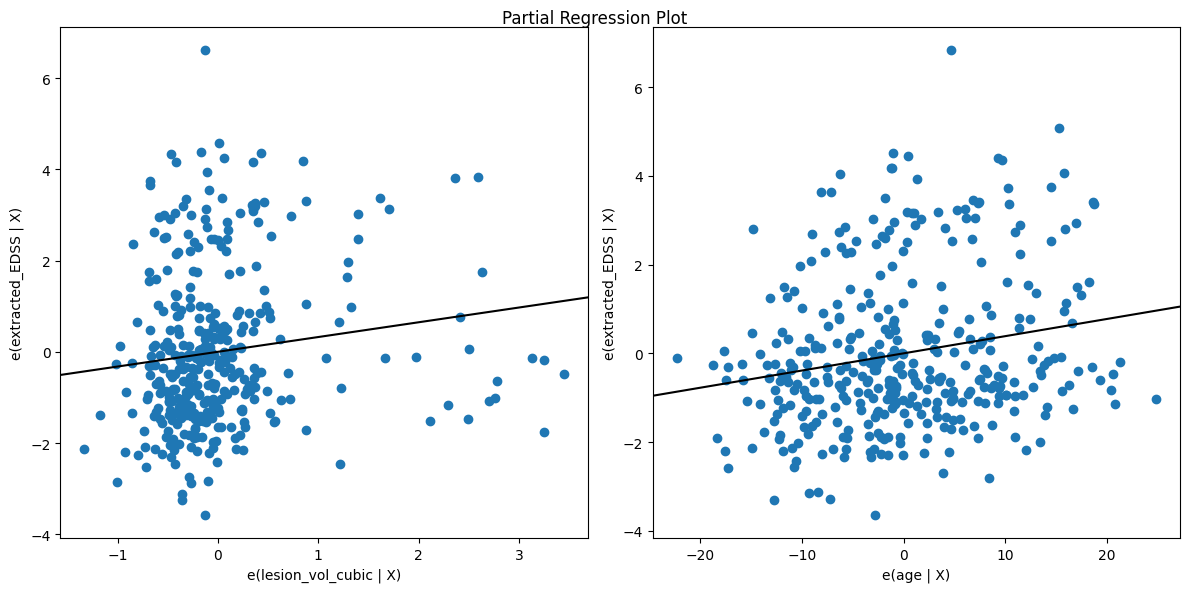

In [100]:
fig = plt.figure(figsize=(12, 6))
sm.graphics.plot_partregress_grid(res, exog_idx=["lesion_vol_cubic", "age"], fig=fig)
plt.show()

Choroid volume is weakly associated with worse EDSS when correcting for age, sex, tiv but not for dzdur

In [125]:
data = df[
    [
        "dz_type3",
        "dz_type",
        "age",
        "sex",
        "tiv",
        "flair_contrast",
        "extracted_EDSS",
        "ARMSS",
        "PRL_LEVEL",
        "lesion_vol_cubic",
        "MSSS",
        "choroid_volume",
        "pineal_volume",
        "pituitary_volume",
        "thalamus",
        "brain",
        "cortical_thickness",
    ]
]
data = data[data["dz_type3"].isin(["MS"])]
data.loc[:, ["dz_type3_factor"]], _ = data["dz_type3"].factorize(sort=False)

data = data[data["flair_contrast"].isin(["WITH", "WITHOUT"])]
# df['extracted_EDSS'] = df['extracted_EDSS'] * 2
data.loc[data["extracted_EDSS"] == ".", "extracted_EDSS"] = None
# data['extracted_EDSS'] = pd.Categorical(data['extracted_EDSS'], ordered=True)

data = pd.concat(
    (
        data,
        pd.get_dummies(data["dz_type"]),
        pd.get_dummies(data["flair_contrast"]),
        pd.get_dummies(data["sex"]),
    ),
    axis=1,
)
data["intercept"] = 1

# predictors = ['age', 'Female', 'tiv', 'choroid_volume', 'pineal_volume', 'pituitary_volume', 'thalamus', 'brain', 'cortical_thickness', 'intercept']
predictors = [
    "age",
    "Female",
    "tiv",
    "PRL_LEVEL",
    "lesion_vol_cubic",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
    "intercept",
]

data = data.dropna()

# mod = OrderedModel(data2['numEDSS'],
#                    data2[predictors].astype('float'), distr='probit', disp=False)
# res = mod.fit(method='nm')

res = sm.OLS(data["MSSS"].astype("float"), data[predictors].astype("float")).fit(
    missing="drop"
)

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   MSSS   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2.136
Date:                Tue, 11 Feb 2025   Prob (F-statistic):             0.0319
Time:                        12:51:33   Log-Likelihood:                -848.85
No. Observations:                 370   AIC:                             1716.
Df Residuals:                     361   BIC:                             1751.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  0.0163      0.012  

### JASP Data

In [102]:
columns = [
    "ms_type",
    "dz_type",
    "dz_type2",
    "dz_type3",
    "dz_type4",
    "dz_type5",
    "age",
    "sex",
    "tiv",
    "flair_contrast",
    "extracted_EDSS",
    "ARMSS",
    "PRL_LEVEL",
    "PRL",
    "IS_PRL", 
    "PRL_LEVEL2",
    "lesion_vol_cubic",
    "MSSS",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume",
    "thalamus",
    "brain",
    "cortical_thickness",
    "dzdur",
]
df_jasp = df[columns]
df_jasp = pd.concat((df_jasp, pd.get_dummies(df_jasp["sex"])), axis=1)
df_jasp = df_jasp.loc[df_jasp["dzdur"] != ".", :]

for i, row in df_jasp.iterrows():
    if row["Female"]:
        df_jasp.loc[i, "Female"] = 1
    else:
        df_jasp.loc[i, "Female"] = 0

    if row["Male"]:
        df_jasp.loc[i, "Male"] = 1
    else:
        df_jasp.loc[i, "Male"] = 0

/tmp/ipykernel_9154/3280957910.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_jasp.loc[i, "Female"] = 1
/tmp/ipykernel_9154/3280957910.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_jasp.loc[i, "Male"] = 0


In [103]:
jasp_dir = Path(
    "/home/srs-9/Projects/ms_mri/monai_analysis/choroid_pineal_pituitary_T1-1/jasp_data"
)

df_jasp.to_csv(jasp_dir / "dataframe.csv")

In [104]:
df["dz_type3"].unique()

array(['MS', 'NIND', 'UNK', 'HC', 'OIND', 'RIS'], dtype=object)

In [105]:
df_jasp3 = df_jasp[df_jasp["dz_type3"].isin(["MS", "NIND", "OIND"])]
df_jasp5 = df_jasp[df_jasp["dz_type5"].isin(["RMS", "PMS", "NIND", "OIND"])]
df_jasp_ms = df_jasp[df_jasp["dz_type5"].isin(["RMS", "PMS"])]

In [106]:
df_jasp3.to_csv(jasp_dir / "dataframe3.csv")
df_jasp5.to_csv(jasp_dir / "dataframe5.csv")
df_jasp_ms.to_csv(jasp_dir / "dataframeMS.csv")

Text(0.5, 1.0, 'Pituitary Volume')

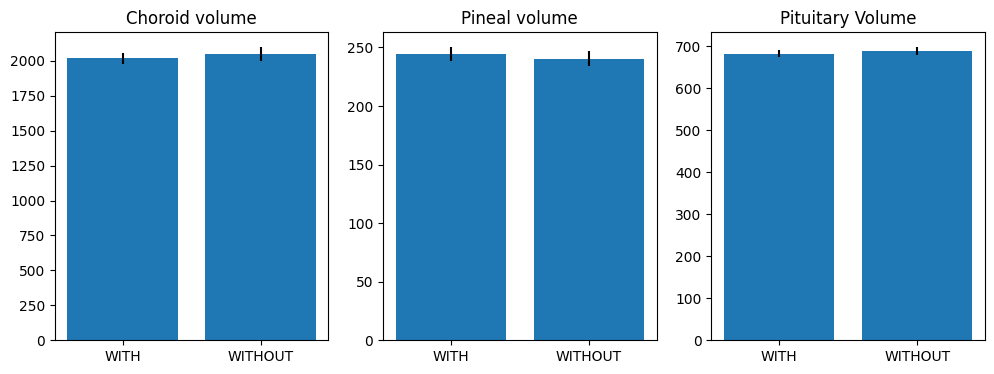

In [65]:
fig, axes = plt.subplots(1,3)
fig.set_figwidth(12)
fig.set_figheight(4)
axes[0].bar(["WITH", "WITHOUT"], [
    df.loc[df['flair_contrast'] == "WITH", "choroid_volume"].mean(),
    df.loc[df['flair_contrast'] == "WITHOUT", "choroid_volume"].mean()
], yerr=[
    df.loc[df['flair_contrast'] == "WITH", "choroid_volume"].sem(),
    df.loc[df['flair_contrast'] == "WITHOUT", "choroid_volume"].sem()
])
axes[0].set_title("Choroid volume")

axes[1].bar(["WITH", "WITHOUT"], [
    df.loc[df['flair_contrast'] == "WITH", "pineal_volume"].mean(),
    df.loc[df['flair_contrast'] == "WITHOUT", "pineal_volume"].mean()
], yerr=[
    df.loc[df['flair_contrast'] == "WITH", "pineal_volume"].sem(),
    df.loc[df['flair_contrast'] == "WITHOUT", "pineal_volume"].sem()
])
axes[1].set_title("Pineal volume")

axes[2].bar(["WITH", "WITHOUT"], [
    df.loc[df['flair_contrast'] == "WITH", "pituitary_volume"].mean(),
    df.loc[df['flair_contrast'] == "WITHOUT", "pituitary_volume"].mean()
], yerr=[
    df.loc[df['flair_contrast'] == "WITH", "pituitary_volume"].sem(),
    df.loc[df['flair_contrast'] == "WITHOUT", "pituitary_volume"].sem()
])
axes[2].set_title("Pituitary Volume")

In [120]:
from scipy import stats

p_values = np.array([0.035, 6.12e-9, 2.2e-6, 0.034, 0.49, 0.001, 0.95, 0.71, 0.66, 0.74, 0.90, 0.64])
adjusted_p_values_bh = stats.false_discovery_control(p_values, method='by')
print("BH Adjusted p-values:", adjusted_p_values_bh)

BH Adjusted p-values: [2.60669697e-01 2.27899792e-07 4.09623810e-05 2.60669697e-01
 1.00000000e+00 1.24128427e-02 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]
